In [1]:
import os

os.environ["SEED"] = "0"
os.environ["TRAIN_DIR"] = "TRAIN"

from src.constant import DATA_DIR, DATABASE_DIR
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.Portfolio import Portfolio
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
import numpy as np

In [2]:
query = """
select
    solver_id,
    filepath,
    cost
from results
join instances on results.instance_id = instances.id
"""

explosion = DB(DATABASE_DIR / "run-phase1-dataset2-993370.db").query2df(query)
expansion = DB(DATABASE_DIR / "run-phase1-dataset2-993505.db").query2df(query)

cluster_compression = DB(DATABASE_DIR / "run-phase1-dataset-993244.db").query2df(query)
cluster_compression = cluster_compression.loc[cluster_compression["filepath"].str.contains("cluster_netgen|compression")]

grid1 = DB(DATABASE_DIR / "run-phase1-dataset2-993371.db").query2df(query)
grid1 = grid1.loc[~grid1["filepath"].str.contains("014.tsp")]
grid2 = DB(DATABASE_DIR / "run-phase1-dataset2-994508.db").query2df(query)

df = pd.concat([
    explosion,
    expansion,
    cluster_compression,
    grid1,
    grid2
]).reset_index(drop=True).rename(columns={"filepath": "instance_id"})
df["cost"] = np.where(df["cost"] == 3000.0, df["cost"] / 10, df["cost"])
df["log_cost"] = np.log(df["cost"] + 1)
df["generator"] = df["instance_id"].apply(lambda x: x.split("/")[-2])

In [3]:
solvers = DB(DATABASE_DIR / "run-phase1-dataset2-993371.db").get_solvers()
solvers

,id,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,GAIN23,GAIN_CRITERION,INITIAL_STEP_SIZE,...,MAX_BREADTH,MAX_CANDIDATES,MOVE_TYPE,PATCHING_A,PATCHING_C,POPULATION_SIZE,RESTRICTED_SEARCH,SUBGRADIENT,SUBSEQUENT_MOVE_TYPE,SUBSEQUENT_PATCHING
0,52980316141715150,0.60,1.0,0.0,0.0,0.7,0.0,1.0,0.0,0.00,...,0.444643,1.000000,0.25,0.6,0.2,0.061224,0.0,0.0,5.0,1.0
1,473831520656465062,0.25,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.50,...,0.470388,0.888889,1.00,0.6,0.2,0.244898,0.0,1.0,3.0,1.0
2,2058572598820127428,0.90,1.0,0.0,3.0,0.6,0.0,1.0,0.0,1.00,...,0.343259,0.555556,0.00,0.6,0.8,0.357143,1.0,1.0,5.0,0.0
3,85558984741464718,0.90,1.0,0.0,3.0,0.6,0.0,0.0,0.0,0.00,...,0.615161,0.444444,0.50,0.8,0.4,0.265306,0.0,1.0,0.0,1.0
4,1627157478422782408,0.10,0.0,0.0,1.0,0.3,0.0,0.0,0.0,0.25,...,0.066931,0.111111,0.50,0.2,0.8,0.520408,1.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,864738382189503080,0.45,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.75,...,0.516131,0.333333,1.00,1.0,0.4,0.193878,1.0,0.0,2.0,0.0
496,1671347939346131212,0.95,0.0,1.0,3.0,1.0,0.0,1.0,1.0,0.25,...,0.054530,0.222222,0.75,0.8,0.0,0.908163,0.0,0.0,3.0,1.0
497,2294257882938389069,1.00,0.0,0.0,1.0,0.5,0.0,1.0,1.0,0.25,...,0.086354,0.777778,0.00,0.0,1.0,0.397959,0.0,1.0,5.0,1.0
498,1680882904861884988,0.55,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.75,...,0.491769,0.333333,0.00,0.4,0.6,0.673469,1.0,1.0,4.0,1.0


In [4]:
df["solver_id"].nunique(), df["instance_id"].nunique()

(500, 100)

In [5]:
df.groupby("generator")["cost"].describe()

,count,mean,std,min,25%,50%,75%,max
generator,,,,,,,,
cluster_netgen,10000.0,92.759172,125.458368,0.0,0.90,11.12,241.6650,300.0
compression,10000.0,77.765086,117.799503,0.0,0.65,6.76,118.5525,300.0
expansion,10000.0,65.050411,110.715344,0.0,0.26,3.55,59.2550,300.0
explosion,10000.0,75.148392,116.659557,0.0,0.62,5.76,102.7275,300.0
grid,10000.0,65.666963,111.961291,0.0,0.26,2.70,61.9700,300.0


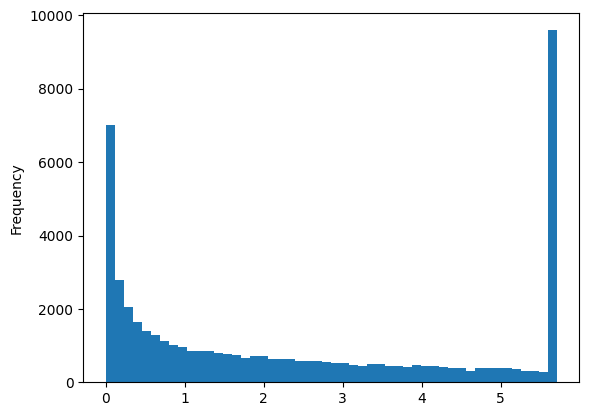

In [16]:
df["log_cost"].plot.hist(bins=50);

In [6]:
(df["cost"] == 300).value_counts(normalize=True)

False    0.81222
True     0.18778
Name: cost, dtype: float64

In [7]:
portfolio = Portfolio.from_solver_class(TSP_LKH_Solver, size=1000)
portfolio[500:]

InstanceList(size=500)[Solver(id=2090634742435262040), Solver(id=631725582268533589), Solver(id=1945739729181897385), Solver(id=262567889846255085), Solver(id=989986425106562966), Solver(id=2025020567756677116), Solver(id=2248928584694663660), Solver(id=1688101106471449679), Solver(id=1536873595736766733), Solver(id=598019363821909053), Solver(id=508648908745550446), Solver(id=603724768688042974), Solver(id=2137108319762193534), Solver(id=56523464364928633), Solver(id=220671427861846825), Solver(id=2137107394592507120), Solver(id=1335827379165800252), Solver(id=472125646861535490), Solver(id=684817598039090964), Solver(id=629524282128046125), Solver(id=281579136574833894), Solver(id=1308651445591944957), Solver(id=538232912979634906), Solver(id=1454238932321312253), Solver(id=2000586403052187622), Solver(id=2015558950952358772), Solver(id=1382261380651557124), Solver(id=132482175614239775), Solver(id=1926844427747939635), Solver(id=707078049897506474), Solver(id=225633897454334588), So

In [ ]:
portfolio[500:]

InstanceList(size=500)[Solver(id=2090634742435262040), Solver(id=631725582268533589), Solver(id=1945739729181897385), Solver(id=262567889846255085), Solver(id=989986425106562966), Solver(id=2025020567756677116), Solver(id=2248928584694663660), Solver(id=1688101106471449679), Solver(id=1536873595736766733), Solver(id=598019363821909053), Solver(id=508648908745550446), Solver(id=603724768688042974), Solver(id=2137108319762193534), Solver(id=56523464364928633), Solver(id=220671427861846825), Solver(id=2137107394592507120), Solver(id=1335827379165800252), Solver(id=472125646861535490), Solver(id=684817598039090964), Solver(id=629524282128046125), Solver(id=281579136574833894), Solver(id=1308651445591944957), Solver(id=538232912979634906), Solver(id=1454238932321312253), Solver(id=2000586403052187622), Solver(id=2015558950952358772), Solver(id=1382261380651557124), Solver(id=132482175614239775), Solver(id=1926844427747939635), Solver(id=707078049897506474), Solver(id=225633897454334588), So

In [13]:
df

,solver_id,instance_id,cost,log_cost,generator
0,1627157478422782408,TSP/TRAIN/explosion/000.tsp,0.91,0.647103,explosion
1,85558984741464718,TSP/TRAIN/explosion/000.tsp,1.06,0.722706,explosion
2,2058572598820127428,TSP/TRAIN/explosion/000.tsp,1.21,0.792993,explosion
3,277732223524031859,TSP/TRAIN/explosion/000.tsp,0.26,0.231112,explosion
4,796686204501835823,TSP/TRAIN/explosion/000.tsp,2.15,1.147402,explosion
...,...,...,...,...,...
49995,473221194665198365,TSP/TRAIN/grid/019.tsp,300.00,5.707110,grid
49996,1515873369927314679,TSP/TRAIN/grid/019.tsp,300.00,5.707110,grid
49997,783744012436790166,TSP/TRAIN/grid/019.tsp,300.00,5.707110,grid
49998,1096317580873199621,TSP/TRAIN/grid/019.tsp,300.00,5.707110,grid
